# Ejercicio N°2
Generar un dataset similar al de la pág. 12 de este apunte (dos conjuntos Gaussianos con diferente media y DS, N=50 c/u, uno con etiqueta A y otro con etiqueta B).
Utilizar la curva ROC para proponer un umbral para un clasificador por mínimo error. Evaluar algunos de los parámetros de calidad (exactitud, precisión, f-measure).
Recalcular para algunas variantes (por ejemplo, acercando las medias de los grupos A y B, cambiando el valor umbral, etc.).
Cómo podrían hacer no supervisado este proceso?

In [1]:
#@title Import de lib a usar y funciones adicionales
from IPython.core.payload import PayloadManager
#import inspector
#inspector.watch_globals()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")


# Funciones adicionales
# ------------------------------------------------------------------------------
def dataset_classic(PamA,PamB,N):
  muA, sigmaA = PamA[0], PamA[1]
  muB, sigmaB = PamB[0], PamB[1]
  
  # dataset balanceado
  datosA = np.random.normal(muA, sigmaA, size=(int(N/2),1)); #creando muestra de datosA
  datosB = np.random.normal(muB, sigmaB, int(N/2))[:,None]; #creando muestra de datosB
  
  # Clase A <-> 0
  claseA = np.zeros(datosA.shape);
  claseB = np.ones(datosB.shape);
  Datos = np.concatenate((datosA,datosB));
  Clase = np.concatenate( (claseA,claseB) );
  return Datos, Clase

# ------------------------------------------------------------------------------
def dataset_newage(PamA,PamB,N):
  muA, sigmaA = PamA[0], PamA[1] # media y desvio estandar
  muB, sigmaB = PamB[0], PamB[1] # media y desvio estandar
  datosA = np.random.normal(muA, sigmaA, size=int(N/2)); #creando muestra de datosA
  datosB = np.random.normal(muB, sigmaB, int(N/2)); #creando muestra de datosB
  
  #datasetA = pd.DataFrame({'x': datosA,'Color': 'r','Clase':'A'})
  #datasetB = pd.DataFrame({'x': datosB,'Color': 'b','Clase':'B'})

  datasetA = pd.DataFrame({'x': datosA,'Color': 'r','Clase': 0})
  datasetB = pd.DataFrame({'x': datosB,'Color': 'b','Clase': 1})
  return datasetA,datasetB
  #eturn pd.concat([datasetA,datasetB], ignore_index=True)

# ------------------------------------------------------------------------------
def clasificador(datos,T):
    prediccion = np.zeros(datos.shape);
    prediccion[datos > T] = 1;
    return(prediccion);

# ------------------------------------------------------------------------------
def medidas(clase,prediccion,N):
    # np.sum(prediccion): cant. total de detecciones + (suma predicciones positivas))
    # N:                  cant. total casos correctos (suma de condiciones positivas)
    # PP: cantidad Predicciones Positivas
    # RP: cantidad Reales positivas

    TP = np.sum( np.logical_and(clase,prediccion));
    RP = np.sum(clase > 0.5) # Caso positivo es "1"
    PP = np.sum(prediccion > 0.5) 
    Precision = TP/PP; 
    Sensibilidad = TP/RP
    FPR = (PP-TP)/RP
    return(Precision,Sensibilidad,FPR,TP,PP)    


Text(0.5, 1.0, 'Hist con seaborn')

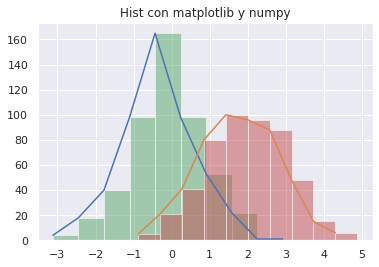

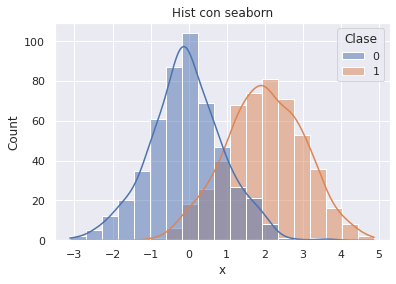

In [2]:
#@title Generación de daset sintético de dos clases

N = 1000; # Cantidad de datos
PamA = [0, 1] # media y desvio estandar
PamB = [2, 1] # media y desvio estandar
datasetA,datasetB = dataset_newage(PamA,PamB,N)
dataset = pd.concat([datasetA,datasetB], ignore_index=True)

# Graficando histogramas
# old school
_,ax = plt.subplots(1,1)
countA,xA = np.histogram(datasetA['x']);
countB,xB = np.histogram(datasetB['x']);
ax.plot(xA[0:len(xA)-1],countA);
ax.plot(xB[0:len(xB)-1],countB);

plt.hist(datasetA['x'],alpha=0.5)
plt.hist(datasetB['x'],alpha=0.5)
ax.set_title('Hist con matplotlib y numpy')

# new school
_,ax1 = plt.subplots(1,1)
sns.histplot(data=dataset, x='x', hue='Clase', alpha = .5, kde=True, ax=ax1)
ax1.set_title('Hist con seaborn')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in long_scalars


Text(0.5, 1.0, 'TPR vs FPR')

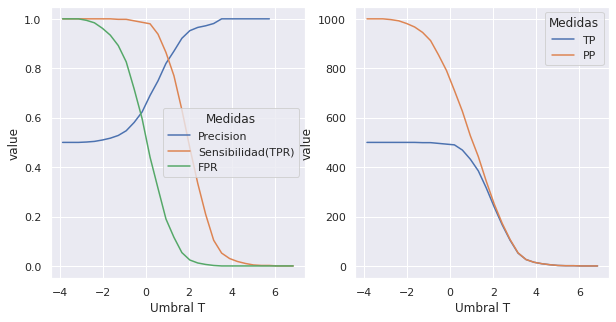

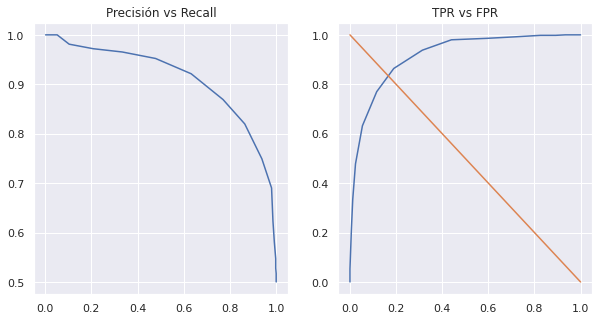

In [3]:
#@title Cálculo de curva ROC (Clasificador ML)

datasetA,datasetB = dataset_newage(PamA,PamB,N)
dataset = pd.concat([datasetA,datasetB], ignore_index=True)

# vectores de valores del umbral T a evaluar
T_vec = np.linspace(dataset['x'].min()-1, dataset['x'].max()+1,30)
Precision = np.zeros(T_vec.shape)
Sensibilidad = np.zeros(T_vec.shape)
TP = np.zeros(T_vec.shape)
PP = np.zeros(T_vec.shape)
FPR = np.zeros(T_vec.shape)

for i in range(T_vec.size):
    T = T_vec[i];
    Predicciones = clasificador(dataset['x'],T);
    
    # Cálculo de medidas de desempeño
    Precision[i],Sensibilidad[i],FPR[i],TP[i],PP[i] = medidas(dataset['Clase'],Predicciones,N); # N es  ant. total casos correctos (suma de condiciones positivas)

medidas_abs = pd.DataFrame({'Umbral T':T_vec,'Precision':Precision,'Sensibilidad(TPR)':Sensibilidad,'FPR':FPR})
medidas_rel = pd.DataFrame({'Umbral T':T_vec,'TP':TP, 'PP':PP})

_,ax = plt.subplots(1,2,figsize=(10, 5))
sns.lineplot(x='Umbral T', y='value', hue='Medidas', data=pd.melt(medidas_abs, 'Umbral T',var_name='Medidas'),ax=ax[0])
sns.lineplot(x='Umbral T', y='value', hue='Medidas', data=pd.melt(medidas_rel, 'Umbral T',var_name='Medidas'),ax=ax[1])

_,ax1 = plt.subplots(1,2,figsize=(10, 5))
ax1[0].plot(Sensibilidad,Precision);
ax1[0].set_title('Precisión vs Recall')

ax1[1].plot(FPR,Sensibilidad)
ax1[1].plot([1,0],[0,1]);
ax1[1].set_title('TPR vs FPR')
  

# Conclusión

Dado que la situación ideal sería,

* Precisión y sensibilidad de 1 y 1, o
* TPR y FPR de 1 y 0 respectivamente

Podemos decir que en la curva de TPR vs FPR, una buena elección sería quedarnos con el punto mas cercano al (0,1). Gráficamente seria la intersección de la curva azul con la curva roja.


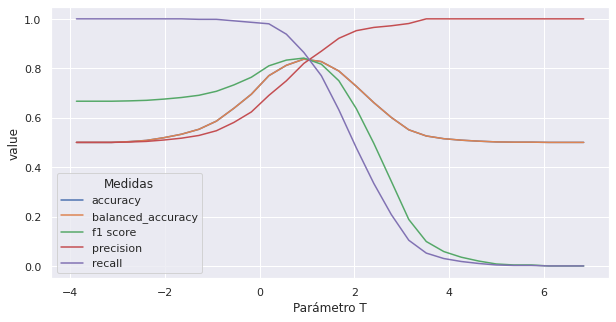

In [4]:
#@title Pd: Mas metricas...con sklearn
def metricas(X,y,y_pred,average):
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn import metrics

  #score = knn.score(X,y)
  m_accuracy = metrics.accuracy_score(y,y_pred)
  m_balanced_accuracy = metrics.balanced_accuracy_score(y,y_pred)
  m_f1 = metrics.f1_score(y,y_pred, average=average)
  m_precision = metrics.precision_score(y,y_pred, average=average,zero_division=1)
  m_recall = metrics.recall_score(y,y_pred, average=average,zero_division=0)

  return m_accuracy,m_balanced_accuracy,m_f1,m_precision,m_recall

# --------------------------------------------------------
sp = T_vec.shape # vector de umbrales
average = 'binary' #'weighted'
m_accuracy = np.zeros(sp)
m_balanced_accuracy = np.zeros(sp)
m_f1 = np.zeros(sp)
m_precision = np.zeros(sp)
m_recall = np.zeros(sp)

# Fiteo
X = dataset['x']
y = dataset['Clase']

for k in range(T_vec.size):
    T = T_vec[k];
    y_pred = clasificador(dataset['x'],T);
    m_accuracy[k],m_balanced_accuracy[k],m_f1[k],m_precision[k],m_recall[k] = metricas(X,y,y_pred,average)

df_score = pd.DataFrame({'Parámetro T':T_vec,'accuracy': m_accuracy,'balanced_accuracy': m_balanced_accuracy,
                        'f1 score':m_f1,'precision':m_precision,'recall':m_recall})

_,ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=pd.melt(df_score, 'Parámetro T',var_name='Medidas'),x='Parámetro T', y='value', hue='Medidas',ax=ax )
